# TM10007 Group 4 -- ECG Data

In this assignment we wil test certain classifiers in order to create a classifier model to distinguish between normal and abnormal ECG's

In [1]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

from IPython.display import display


pd.set_option('display.max_rows', 5)



## 1. Data loading, cleaning and visualization

Below we load the ECG data, convert it to a dataframe an clean the data.First we are going to start with loading the CS file into a dataframe

In [2]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

df = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(df.index)}')
print(f'The number of columns: {len(df.columns)}')

Cloning into 'TM10007_ML_ECG_group4'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 256 (delta 98), reused 62 (delta 45), pack-reused 124
Receiving objects: 100% (256/256), 69.46 MiB | 10.70 MiB/s, done.
Resolving deltas: 100% (135/135), done.
The number of samples: 827
The number of columns: 9001


Now we are going to test if there is data missing in our dataset. We conclude that NaNs are missing data and if an entire row or column has zero's, this is also seen as missing data.

In [3]:
# Checking if there are any NaN or None values in the dataset
print(f'Are there any NaN or None values in the dataset? = '+ str(df.isnull().values.any()))

Are there any NaN or None values in the dataset? = False


In [4]:
# Test dataset for missing rows/columns

# Columns
columnswithzeros = []
for (colname, colval) in df.iteritems():
  if (colval.to_numpy()==0).all() == True:
    print(f'All values are zero in column {colname}')
    columnswithzeros.append(colname)

if len(columnswithzeros) == 0:
  print('There are no columns with only zeros')
  
# Rows
rowswithzeros = []
for (index, rowval) in df.iterrows():
  if (rowval.to_numpy()==0).all() == True: 
    print(f'All values are zero in row {index}')
    rowswithzeros.append(index)

if len(rowswithzeros) == 0:
  print('There are no rows with only zeros')

There are no columns with only zeros
There are no rows with only zeros


Lasty we are going to check if there are patiens or features with multiple zeros in order to see if those zero's could represent missing data

In [5]:
# Test patients with multiple zero's 
def check_for_zeros_in_patients(dataframe): 
  patients_with_zeros=[]
  for (index, rowval) in dataframe.iterrows():
    row = rowval.to_numpy()[:-1] #change to numpy to delete row names en the last row of labels
    if (row==0).any() == True: #if there is a zero in the row
      number_of_zeros = 0
      for i in range(len(row)): #check the entire length of the row for
        if row[i] == 0:
          number_of_zeros += 1
      patients_with_zeros.append({"patient number": index, "number of zeros": number_of_zeros}) 
  print(patients_with_zeros)
  print(f' There are {len(patients_with_zeros)} patients with zeros')

check_for_zeros_in_patients(df)

# Test features with multiple zero's
def check_for_zeros_in_features(dataframe):
  features_with_zeros = []
  for (colname, colval) in dataframe.iteritems():
    if colname == "label": #don't check the column label
      continue
    col = colval.to_numpy()
    if (col==0).any() == True: 
      number_of_zeros = 0
      for i in range(len(col)):
        if col[i] == 0:
          number_of_zeros += 1
      features_with_zeros.append({"feature": colname, "number of zeros": number_of_zeros}) 

  print(features_with_zeros)
  print(f'There are {len(features_with_zeros)} features with zeros')

check_for_zeros_in_features(df)

[{'patient number': 177, 'number of zeros': 750}, {'patient number': 251, 'number of zeros': 750}, {'patient number': 269, 'number of zeros': 750}, {'patient number': 321, 'number of zeros': 750}, {'patient number': 323, 'number of zeros': 750}, {'patient number': 385, 'number of zeros': 750}, {'patient number': 434, 'number of zeros': 750}, {'patient number': 446, 'number of zeros': 750}, {'patient number': 537, 'number of zeros': 750}, {'patient number': 542, 'number of zeros': 750}, {'patient number': 575, 'number of zeros': 750}, {'patient number': 601, 'number of zeros': 750}, {'patient number': 784, 'number of zeros': 750}, {'patient number': 790, 'number of zeros': 750}]
 There are 14 patients with zeros
[{'feature': '6_0', 'number of zeros': 1}, {'feature': '6_1', 'number of zeros': 1}, {'feature': '6_2', 'number of zeros': 1}, {'feature': '6_3', 'number of zeros': 1}, {'feature': '6_4', 'number of zeros': 1}, {'feature': '6_5', 'number of zeros': 1}, {'feature': '6_6', 'number

Conclusion: there are patients with multiple zero's (14 with 750 zero's), however these are not centered at certain features. This means that these zero's could indeed represent missing data and are therefore be replaced with the mean of that feature for the label of that patient.


In [6]:
# Create a list of means per label and feature
df_normal = df[df["label"]== 0]
df_abnormal = df[df["label"]== 1]
df_normal_mean = {}
df_abnormal_mean = {}

for (colname, colval) in df_normal.iteritems():
  if colname == "label":
    continue
  df_normal_mean[colname] = (colval.to_numpy().mean())

for (colname, colval) in df_abnormal.iteritems():
   if colname == "label":
     continue
   df_abnormal_mean[colname] = (colval.to_numpy().mean())

print(df_normal_mean)
print(df_abnormal_mean)

{'0_0': 469.3470502749906, '0_1': 70.6996088100883, '0_2': 40.62862319412772, '0_3': 31.173712757341196, '0_4': 31.54865255065674, '0_5': 43.429041907720126, '0_6': 55.84330178557533, '0_7': 39.003234790730296, '0_8': 25.226056527835073, '0_9': 19.172557363950904, '0_10': 22.256479757512093, '0_11': 26.297794080493855, '0_12': 30.72142554697234, '0_13': 31.66812879477023, '0_14': 30.372431869497436, '0_15': 31.39360833307335, '0_16': 33.352713458528626, '0_17': 34.58298517061866, '0_18': 38.503790736701596, '0_19': 38.319370868571966, '0_20': 43.68758295776539, '0_21': 35.40656152935558, '0_22': 34.785388992521355, '0_23': 35.78567016939342, '0_24': 34.731802677249625, '0_25': 30.919289833729547, '0_26': 28.888807336884312, '0_27': 25.994899925065507, '0_28': 25.159825027510696, '0_29': 25.99326216312191, '0_30': 28.119506596374972, '0_31': 30.27387223375175, '0_32': 31.95308050038741, '0_33': 30.74525789346074, '0_34': 31.30504561055703, '0_35': 31.8473466118405, '0_36': 32.1852669540

In [7]:
# Replace zeros with the correct mean of that feature and label
cleaned_data = df.copy().to_numpy() #make a copy of original data and change into numpy array

column_names = list(df.columns.values) #make a list of the column names

for i in range(len(cleaned_data)):
  for j in range(len(cleaned_data[0])-1):
    if cleaned_data[i,j] == 0:
      label = cleaned_data[i,-1]
      if label == 0:
        col_name = column_names[j]
        cleaned_data[i,j] = df_normal_mean[col_name]
      else:
        col_name = column_names[j]
        cleaned_data[i,j] = df_abnormal_mean[col_name]

# Change back from numpy array to dataframe and check if there are no zeros left and the dimension are the same
cleaned_df = pd.DataFrame(cleaned_data, columns = column_names)
print(f'The number of samples: {len(cleaned_df.index)}')
print(f'The number of columns: {len(cleaned_df.columns)}')
check_for_zeros_in_patients(cleaned_df)
check_for_zeros_in_features(cleaned_df)

The number of samples: 827
The number of columns: 9001
[]
 There are 0 patients with zeros
[]
There are 0 features with zeros


Lastly we want to categorize our dataset to see how many patients have a normal and how many patients have an abnormal ECG. 


In [8]:
# How many patients have a normal or abnormal ECG?
count0= (cleaned_df['label'] == 0).sum()
count1= (cleaned_df['label'] == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')
# Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal

There are 681 patients with label 0
There are 146 patients with label 1


## 2. Creating the experimental setup
Below we split the dataset in test data and training data. Then we further split the trainingdata in order to make different training and validation sets for our different classifiers

In [9]:
# Split the whole data set in a training and test set
features = cleaned_df.loc[:, cleaned_df.columns !="label"].to_numpy()
labels = cleaned_df["label"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split (features, labels, train_size = 0.8, random_state = 42) 

## 3. Feature scaling


There are multiple ways to scale features. Since the feature distribution is unclear, we will use normalization.

In [10]:
# 1. Standardization of the data
scaler_standard = StandardScaler()
x_scaled_standard = scaler_standard.fit_transform(x_train)

# 2. Min-max scaling
scaler_minmax = MinMaxScaler()
x_scaled_minmax = scaler_minmax.fit_transform(x_train)

# 3. Robust scaling
scaler_robust= RobustScaler()
x_scaled_robust = scaler_robust.fit_transform(x_train)

x_scaled = {"standerd":x_scaled_standard, "minmax":x_scaled_minmax, "robust": x_scaled_robust}


Hallo tekst

In [11]:
# Blokje backup

## 4. Feature selection

Hallo tekst

(661, 9000)
(661, 9000)
(661, 306)


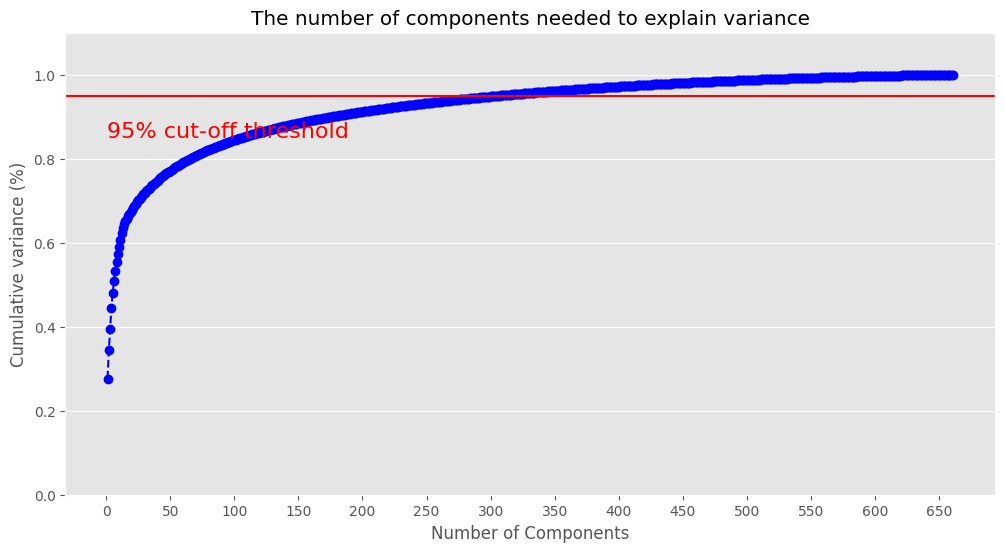

In [43]:
# PCA

from sklearn.decomposition import PCA
import seaborn
import numpy as np
import matplotlib.pyplot as plt

# ### plotting method ###

# # Determine amount of Principal Components
# pca_1 = PCA(n_components =  None)
# pca_1.fit(x_scaled_standard)
# variance = pca_1.explained_variance_ratio_
# eigenvalues = pca_1.explained_variance_

# # Bar plot
# eigenvalues=eigenvalues[:10]
# plt.subplot(1, 3, 1)
# plt.bar(range(1,len(eigenvalues )+1), eigenvalues )
# plt.ylabel('Explained variance')
# plt.xlabel('Components')
# plt.plot(range(1,len(eigenvalues )+1),
#          np.cumsum(eigenvalues),
#          c='red',
#          label="Cumulative Explained Variance")
# plt.axvline(x=1, linewidth=1, color='b', alpha=0.5) #Kaiser's rule
# plt.legend(loc='upper left')

# # Scree plot
# plt.subplot(1, 3, 2)
# plt.style.use("ggplot") 
# plt.plot(variance[0:20], marker='o')
# plt.axhline(y=1, linewidth=1, color='r', alpha=0.5) #Kaiser's rule
# plt.xlabel("Eigenvalue number")
# plt.ylabel("Eigenvalue size")
# plt.title("Scree Plot")



# # nodig als we uiteindelijk een keuze maken in hoeveel components
# k = 
# pca_2 = PCA(n_components =  k)
# pca_2.fit(x_scaled_standard)
# x_pca = pca_2.transform(x_scaled_standard)
# plt.subplot(1, 3, 3)
# seaborn.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=y_train)






### threshold at 95% method ###

# applying pca
pca = PCA(n_components = 0.95)
pca_fit = pca.fit(x_scaled_minmax)
train_reduced_pca = pca.transform(x_scaled_minmax)

print(x_train.shape)
print(x_scaled_minmax.shape)
print(train_reduced_pca.shape)

# plot
pca_figure = PCA().fit(x_scaled_minmax)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 662, step=1)
y = np.cumsum(pca_figure.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()


Hallo tekst

In [13]:
# Different feature selection

Hallo tekst

In [14]:
# Different feature selection

## 5. Parameter tuning


Hallo tekst

In [15]:
# SVM


Hallo tekst

In [16]:
# Neural network

Hallo tekst

In [17]:
# Random forest

Hallo tekst

In [18]:
# Loop